In [44]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import gc

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from gensim.models import Word2Vec

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
                          UpSampling1D, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, concatenate, \
                          Reshape, Dropout, BatchNormalization, GlobalAveragePooling1D

from keras.utils import plot_model, to_categorical
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.utils.vis_utils import plot_model

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pd.set_option('max_colwidth', 250)

In [2]:
#path = os.path.join('../../Data/')
#path_text_encoders = os.path.join('../03_Preparacion_de_Datos/')

#EMbedding words = word2vec_model_v2
#Encoder = encoder_text_V1.h5

In [3]:
#print (os.listdir(path_text_encoders))

In [4]:
data = pd.read_csv('data_filtered_20190422.csv', sep = ';')
data_customers = pd.read_csv('customers_data_2.csv', sep = ';', nrows = 70000)
#data_text = pd.read_csv('Texto_PreProcesado_v2.csv', sep = ';')
#data_text = data_text[['item_id', 'text']]

In [5]:
data.head()

,item_id,availability_date,brand,category,name,price
0,A28233506,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo masculino con textura de mujer,"{'final': 199, 'currency': 'EUR'}"
1,A29054782,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo doble faz de mujer con cinturón a tono,"{'final': 149, 'currency': 'EUR'}"
2,A27354432,NaN,Woman El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo largo de antelina de mujer Woman El Corte Inglés,"{'final': 89.99, 'currency': 'EUR'}"
3,A28302706,NaN,Lloyd's,"['Moda', 'Mujer', 'Abrigos']",Chaqueta térmica de mujer Lloyds con efecto cortavientos,"{'final': 129, 'currency': 'EUR'}"
4,A27435502,NaN,Lloyd's,"['Moda', 'Mujer', 'Abrigos']",Parka 100% algodón de mujer Lloyds con capucha,"{'final': 149, 'currency': 'EUR'}"


In [6]:
data_customers.head()

,date,item_id,brand,PRICE,customer_id,text
0,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
1,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
2,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
3,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
4,20190101,A26870590,Fórmula Joven,"19,99",0,Vestido laminado de mujer Fórmula Joven con escote en pico


In [7]:
#data_text.head()

In [8]:
data_customers.columns = data_customers.columns.str.strip()
data_customers.PRICE = data_customers.PRICE.apply(lambda x: x.strip())
#data_customers.brand = data_customers.brand.apply(lambda x: x.strip())
data_customers.PRICE = data_customers.PRICE.str.replace('.', '')
data_customers.PRICE = data_customers.PRICE.str.replace(',', '.')
data_customers.PRICE = pd.to_numeric(data_customers['PRICE'])
data_customers.item_id = data_customers.item_id.apply(lambda x: x.strip())
data.item_id = data.item_id.apply(lambda x: x.strip())

In [9]:
data.columns = data.columns.str.strip()
#data['availability_date'].fillna(0, inplace=True)
data_customers['item_age'] = -1 * (data_customers['date'] - data['availability_date'])
data_customers['item_age'].fillna(0, inplace=True)

In [10]:
customers_unique = data_customers.customer_id.unique()
items_unique = data_customers.item_id.unique()
brand_unique = data_customers.brand.unique()

print (f'We have {len(customers_unique)} unique users and {len(items_unique)} unique items and {len(brand_unique)} unique brands')

We have 720 unique users and 23279 unique items and 1568 unique brands


### We need integer data to be able to feed the NN

In [11]:
customers_map = {i:val for i,val in enumerate(customers_unique)}
customers_map_inv = {val:i for i,val in enumerate(customers_unique)}

items_map = {i:val for i,val in enumerate(items_unique)}
items_map_inv = {val:i for i,val in enumerate(items_unique)}

brands_map = {i:val for i,val in enumerate(brand_unique)}
brands_map_inv = {val:i for i,val in enumerate(brand_unique)}

In [12]:
data_customers['customer_id_int'] = data_customers['customer_id'].map(customers_map_inv)
data_customers['item_id_int'] = data_customers['item_id'].map(items_map_inv)
data_customers['brand_id'] = data_customers['brand'].map(brands_map_inv)
data_customers.shape

(70000, 10)

In [13]:
data_score = data_customers.groupby(['customer_id_int', 'item_id_int']).size().to_frame('score').reset_index().sort_values(by = 'score',ascending = False)

In [14]:
data_final = pd.merge(data_customers, data_score, how = 'inner')
#data_final = pd.merge(data_final, data_text, how = 'inner')
#data_final = data_customers

In [15]:
#remove duplicates due to agrupation, if a customer bought a item 2 times i only want 1 row with score 2, instead of 2 rows
data_final.drop_duplicates(inplace=True)
data_final.dropna(how = 'any', inplace = True)

print(data_final.shape)
data_final.head()

(35344, 11)


,date,item_id,brand,PRICE,customer_id,text,item_age,customer_id_int,item_id_int,brand_id,score
0,20190101,A26036172,Tintoretto,27.99,0,Vestido de mujer Tintoretto de flores con lazada,0.0,0,0,0,8
4,20190115,A26036172,Tintoretto,27.99,0,Vestido de mujer Tintoretto de flores con lazada,0.0,0,0,0,8
8,20190101,A26870590,Fórmula Joven,19.99,0,Vestido laminado de mujer Fórmula Joven con escote en pico,0.0,0,1,1,4
12,20190103,MP_0659870_3014,Gabrielle,76.10,1,Abrigo de mujer Gabrielle negro con avalorios,0.0,1,2,2,1
13,20190103,A26011856,Antea Plus,84.50,1,Abrigo largo de mujer talla grande Antea Plus con cuello alto,0.0,1,3,3,1


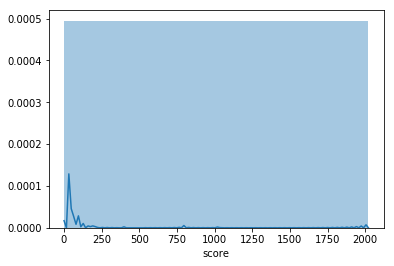

In [16]:
sns.distplot(data_score['score'], bins = 1);

## Vectorize sentences

In [17]:
MAX_NB_WORDS = 30_000 #decided by cumsum wordcount plot (Script 01)
MAX_SEQUENCE_LENGTH = 24 #decided by max words in a product (Script 00)
EMBEDDING_DIM = 100 #Same dim as our W2V embedding

all_text = data_final['text']
all_text = all_text.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, )
tokenizer.fit_on_texts(all_text)

data_sequences = tokenizer.texts_to_sequences(data_final['text'])
data_vec = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11765 unique tokens.


In [18]:
len(data_vec)

35344

In [19]:
data_final.shape

(35344, 11)

In [20]:
modelWV = Word2Vec.load('word2vec_model_v2')
#encoder = load_model('encoder_text_V1.h5')

In [21]:
#lstm_emb = encoder.get_layer('ENCODER')
#encoder.summary()

In [22]:
word_vectors = modelWV.wv
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in modelWV:
        embedding_matrix[i] = modelWV[word]
    else:
        embedding_matrix[i] = np.random.rand(1, EMBEDDING_DIM)[0]
            

del(word_vectors)
gc.collect()

C:\Users\aeroengy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\aeroengy\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


0

## Output

In [23]:
del (data, data_score, data_customers)

In [24]:
gc.collect()

28

In [25]:
CAT_ITEMS = len(items_unique)

In [26]:
#train_df, test_df = train_test_split(data_final, test_size=0.1, random_state = 12)
#print(f'{len(train_df)} train rows, {len(test_df)} validate rows')

In [27]:
#train_items_encoded = to_categorical(train_df['item_id_int'], num_classes = CAT_ITEMS)
#test_items_encoded = to_categorical(test_df['item_id_int'], num_classes = CAT_ITEMS)
items_encoded = to_categorical(data_final['item_id_int'], num_classes = CAT_ITEMS)
print(items_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [28]:
items_encoded.shape

(35344, 23279)

## Scale continuous data

In [30]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
data_to_scale = data_final[['PRICE','score', 'item_age']]
scaled_data = scaler.fit_transform(data_to_scale.values)

In [32]:
data_final['PRICE'] = scaled_data[:,0]
data_final['score'] = scaled_data[:,1]
data_final['item_age'] = scaled_data[:,2]

data_final['power_price'] = np.power(scaled_data[:,0], 2)
data_final['power_score'] = np.power(scaled_data[:,1], 2)
data_final['power_item_age'] = np.power(scaled_data[:,1], 2)

data_final['sqrt_price'] = np.sqrt(scaled_data[:,0])
data_final['sqrt_score'] = np.sqrt(scaled_data[:,1])
data_final['sqrt_item_age'] = np.sqrt(scaled_data[:,1])


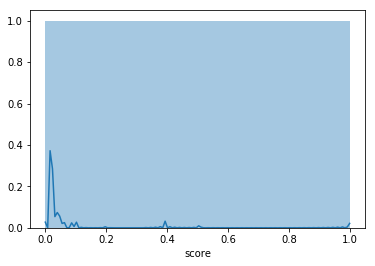

In [33]:
sns.distplot(data_final['score'], bins = 1);

## Architecture

In [34]:
data_final.head(3)

,date,item_id,brand,PRICE,customer_id,text,item_age,customer_id_int,item_id_int,brand_id,score,power_price,power_score,power_item_age,sqrt_price,sqrt_score,sqrt_item_age
0,20190101,A26036172,Tintoretto,0.002036,0,Vestido de mujer Tintoretto de flores con lazada,0.0,0,0,0,0.003465,0.000004,0.000012,0.000012,0.045126,0.058867,0.058867
4,20190115,A26036172,Tintoretto,0.002036,0,Vestido de mujer Tintoretto de flores con lazada,0.0,0,0,0,0.003465,0.000004,0.000012,0.000012,0.045126,0.058867,0.058867
8,20190101,A26870590,Fórmula Joven,0.001444,0,Vestido laminado de mujer Fórmula Joven con escote en pico,0.0,0,1,1,0.001485,0.000002,0.000002,0.000002,0.037997,0.038538,0.038538


In [39]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
brand_id_input = Input(shape = [1], name = 'brand')

price_input = Input(shape = [1], name = 'price')
score_input = Input(shape = [1], name = 'score')
item_age_input = Input(shape = [1], name = 'item_age')

price_power_input = Input(shape = [1], name = 'power_price')
score_power_input = Input(shape = [1], name = 'power_score')
item_age_power_input = Input(shape = [1], name = 'power_item_age')

price_sqrt_input = Input(shape = [1], name = 'sqrt_price')
score_sqrt_input = Input(shape = [1], name = 'sqrt_score')
item_age_sqrt_input = Input(shape = [1], name = 'sqrt_item_age')

#text_input = Input(shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), name = 'text_input')

sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH, ), name = 'text')

embedding_size = 50

user_embedding = Embedding(output_dim=embedding_size, input_dim = customers_unique.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim = items_unique.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)
brand_embedding = Embedding(output_dim=embedding_size, input_dim = brand_unique.shape[0],
                           input_length=1, name='brand_embedding')(brand_id_input)

text_embedding = Embedding(*embedding_matrix.shape, weights = [embedding_matrix], trainable = False)(sequence_input)

#text_embedding = encoder([text_input, text_input])

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)
gav_pool = GlobalAveragePooling1D()(text_embedding)
brand_vecs = Reshape([embedding_size])(brand_embedding)

x1 = concatenate([user_vecs, item_vecs, brand_vecs, price_input, gav_pool, item_age_input, score_input,
                 price_power_input, score_power_input, item_age_power_input,
                 price_sqrt_input, score_sqrt_input, item_age_sqrt_input], name = 'VECTOR_PRODUCTO')

x2 = Dropout(0.4)(x1)
x3 = Dense (256, activation = 'relu')(x2)
x4 = Dropout(0.3)(x3)
x5 = Dense(128, activation = 'relu')(x4)
x6 = Dropout(0.2)(x5)
x7 = Dense(32, activation = 'relu')(x6)
x8 = Dropout(0.2)(x7)

output = Dense(CAT_ITEMS, activation = 'softmax' )(x8)

model = Model(inputs=[user_id_input, item_id_input, brand_id_input, price_input, sequence_input, item_age_input, score_input,
                     price_power_input, score_power_input, item_age_power_input,
                     price_sqrt_input, score_sqrt_input, item_age_sqrt_input], 
              outputs = output)

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
brand (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
text (InputLayer)               (None, 24)           0                                            
__________________________________________________________________________________________________
user_embed

In [40]:
data_final.head(2)

,date,item_id,brand,PRICE,customer_id,text,item_age,customer_id_int,item_id_int,brand_id,score,power_price,power_score,power_item_age,sqrt_price,sqrt_score,sqrt_item_age
0,20190101,A26036172,Tintoretto,0.002036,0,Vestido de mujer Tintoretto de flores con lazada,0.0,0,0,0,0.003465,0.000004,0.000012,0.000012,0.045126,0.058867,0.058867
4,20190115,A26036172,Tintoretto,0.002036,0,Vestido de mujer Tintoretto de flores con lazada,0.0,0,0,0,0.003465,0.000004,0.000012,0.000012,0.045126,0.058867,0.058867


In [41]:
history = model.fit([data_final['customer_id_int'], data_final['item_id_int'], 
                     data_final['brand_id'], data_final['PRICE'],
                     data_vec, data_final['item_age'], data_final['score'],
                     data_final['power_price'], data_final['power_score'], data_final['power_item_age'],
                     data_final['sqrt_price'], data_final['sqrt_score'], data_final['sqrt_item_age']],
                     items_encoded,
                     epochs = 20, 
                     batch_size = 64,
                     shuffle = True)

#Epoch 10 = loss = 7.8485 & acc = 0.0532
#Epoch 20 = loss = 5.4801 & acc = 0.1083

Epoch 1/20
35344/35344 [==============================] - 56s 2ms/step - loss: 9.9405 - acc: 0.0023
Epoch 2/20
35344/35344 [==============================] - 54s 2ms/step - loss: 9.3850 - acc: 0.0055
Epoch 3/20
35344/35344 [==============================] - 51s 1ms/step - loss: 8.9271 - acc: 0.0099
Epoch 4/20
35344/35344 [==============================] - 68s 2ms/step - loss: 8.5234 - acc: 0.0153
Epoch 5/20
35344/35344 [==============================] - 67s 2ms/step - loss: 8.1664 - acc: 0.0212
Epoch 6/20
35344/35344 [==============================] - 61s 2ms/step - loss: 7.8465 - acc: 0.0259
Epoch 7/20
35344/35344 [==============================] - 54s 2ms/step - loss: 7.5564 - acc: 0.0321
Epoch 8/20
35344/35344 [==============================] - 62s 2ms/step - loss: 7.2941 - acc: 0.0394
Epoch 9/20
35344/35344 [==============================] - 61s 2ms/step - loss: 7.0638 - acc: 0.0448
Epoch 10/20
35344/35344 [==============================] - 58s 2ms/step - loss: 6.8540 - acc: 0.0535

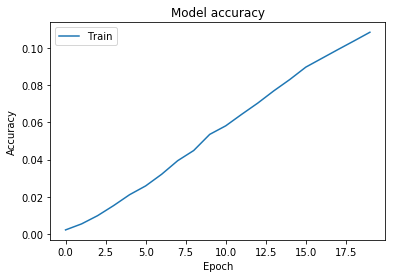

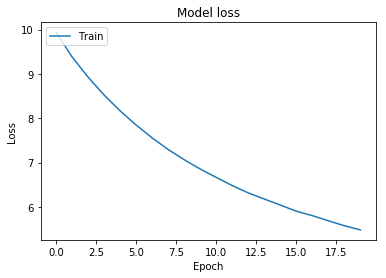

In [46]:
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_pred = model.predict([data_final['customer_id_int'], data_final['item_id_int'], 
                     data_final['brand_id'], data_final['PRICE'],
                     data_vec, data_final['item_age'], data_final['score'],
                     data_final['power_price'], data_final['power_score'], data_final['power_item_age']],
                     verbose = 1)

In [ ]:
score = model.evaluate([data_final['customer_id_int'], data_final['item_id_int'], 
                     data_final['brand_id'], data_final['PRICE'],
                     data_vec, data_final['item_age'], data_final['score'],
                     data_final['power_price'], data_final['power_score'], data_final['power_item_age']],
                     items_encoded, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Test loss = 8.7091
# Test acc = 0.0089

In [ ]:
test_pred.shape

In [ ]:
test_pred[:10]

In [ ]:
CUSTOMER = 101

In [ ]:
top10 = test_pred[CUSTOMER].argsort()[-1000:][::-1] #items positions

In [ ]:
items_unique[top10]

In [ ]:
data = pd.read_csv('data_filtered_20190422.csv', sep = ';')

In [ ]:
data[data['item_id'].isin(items_unique[top10])]

In [ ]:
data_final.loc[CUSTOMER]['customer_id_int']

In [ ]:
data_final[data_final.customer_id_int == 101]

In [ ]:
del data
gc.collect()